In [1]:
# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax
import jax.numpy as jnp
import jaxkd as jk

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from scipy.spatial import KDTree

key = jax.random.PRNGKey(83)

## Visualization

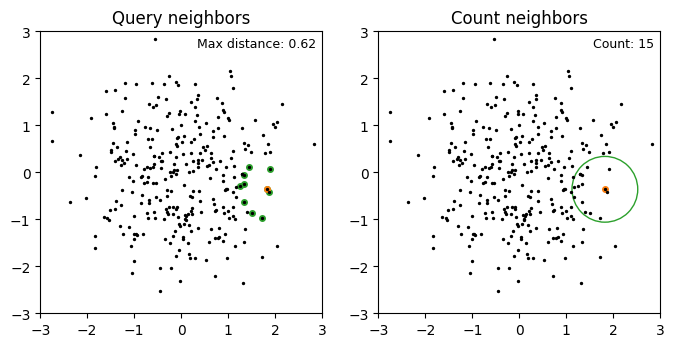

In [2]:
# Generate a few random points
n_points = 300
n_neighbors = 10
count_radius = 0.7
key, subkey = jax.random.split(key)
points = jax.random.normal(subkey, shape=(n_points, 2))
tree = jk.build_tree(points)
neighbors, distances = jk.query_neighbors(tree, points[0], k=n_neighbors)
counts = jk.count_neighbors(tree, points[0], r=count_radius)

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
axes[0].set_title('Query neighbors')
axes[0].scatter(*points[neighbors].T, s=16, c='C2')
axes[0].text(0.98, 0.98, f'Max distance: {jnp.max(distances):.2f}', fontsize=9, ha='right', va='top', color='k', transform=axes[0].transAxes)
circle = plt.Circle(points[0], count_radius, color='C2', fill=False)
axes[1].set_title('Count neighbors')
axes[1].add_artist(circle)
axes[1].text(0.98, 0.98, f'Count: {counts}', fontsize=9, ha='right', va='top', color='k', transform=axes[1].transAxes)
for ax in axes:
    ax.scatter(*points[0], s=16, c='C1')
    ax.scatter(*points.T, s=2, c='k')
    ax.set(xlim=(-3, 3), ylim=(-3, 3), aspect='equal')
plt.show()

## Gradients

The simplest way to use the tree would be to keep the points fixed and optimize some function over neighbors. It might be convenient to have everything in JAX, but fundamentally this would be just as easy with a static neighbor array built using `scipy.spatial.KDTree`.

A more fun way to use the tree is to allow points to move and dynamically update the neighbors at every step of the optimization. The entire loop can be JIT-compiled and run on the GPU!

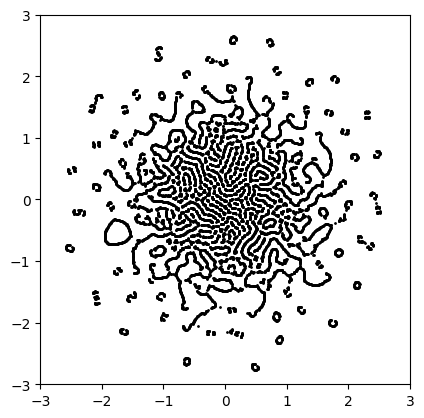

In [3]:
# Nearest neighbors at fixed distances -- the result depends strongly on k, the distance scale, and the number of points!
def loss_func(points):
    tree = jk.build_tree(points)
    neighbors, _ = jk.query_neighbors(tree, points, k=25)
    distances = jnp.linalg.norm(points[:,None] - points[neighbors][:,1:], axis=-1) # recompute without self-distance for finite gradient
    return jnp.sum(jnp.square(distances - 0.005 * jnp.arange(neighbors.shape[-1])[1:]))

@jax.jit
def step(points, _):
    loss, grad = jax.value_and_grad(loss_func)(points)
    points = points - 0.01 * grad
    return points, (points, loss)

# Optimize location of random initial points
n_points = 10_000
key, subkey = jax.random.split(key)
points = jax.random.normal(subkey, shape=(n_points, 2))
points, (points_hist, loss_hist) = jax.lax.scan(step, points, None, length=50)

# Plot
plt.scatter(*points.T, s=1, c='k')
plt.gca().set(xlim=(-3, 3), ylim=(-3, 3), aspect='equal')
plt.show()

In [ ]:
# Animate the optimization, points arrange themselves on lines with equal spacing
fig, ax = plt.subplots(figsize=(5, 5))
s = ax.scatter(*points_hist[0].T, s=1, c='k')
ax.set(xlim=(-3, 3), ylim=(-3, 3))
def update(i):
    s.set_offsets(points_hist[i])
    return s,
ani = FuncAnimation(fig, update, frames=range(0, len(points_hist)), interval=1000/10, blit=True)
plt.close()
HTML(ani.to_jshtml())

## Clustering

The ability to dynamically build a tree within JIT also enables us to write iterative algorithms like $k$-means easily. We just have to use `segment_sum` to compute the mean with a variable number of points per cluster. This is also implemented in `jaxkd.extras`.

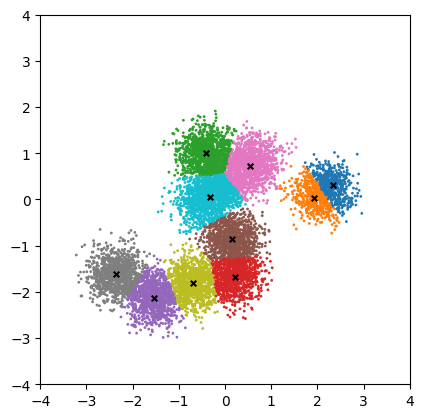

In [5]:
# Make mock cluster data
n_clusters = 10
n_points_per_cluster = 1_000
key, *subkeys = jax.random.split(key, 4)
points = (
    jax.random.normal(subkeys[0], shape=(n_clusters, 2)) # cluster center
    + 0.3 * jax.random.normal(subkeys[1], shape=(n_points_per_cluster, n_clusters, 2)) # cluster spread
).reshape(-1, 2)
initial_centroids = jax.random.choice(subkeys[2], points, shape=(n_clusters,)) # initial means

# Run a few k-means iterations
n_iterations = 50
def k_means_step(centroids, _):
    tree = jk.build_tree(centroids)
    nearest_centroid = jk.query_neighbors(tree, points, k=1)[0].squeeze(-1)
    total = jax.ops.segment_sum(points, nearest_centroid, len(centroids))
    count = jax.ops.segment_sum(jnp.ones_like(points), nearest_centroid, len(centroids))
    centroids = total / count
    return centroids, (centroids, nearest_centroid)
centroids, (centroid_hist, cluster_hist) = jax.lax.scan(k_means_step, initial_centroids, length=50)

# Plot the result
plt.scatter(*points.T, c=cluster_hist[-1], s=1, cmap='tab20', vmin=0, vmax=n_clusters)
plt.scatter(*centroids.T, c='k', s=16, marker='x')
plt.gca().set(xlim=(-4, 4), ylim=(-4, 4), aspect='equal')
plt.show()

In [ ]:
# Animate k-means iterations
fig, ax = plt.subplots(figsize=(5, 5))
s1 = ax.scatter(*points.T, c=cluster_hist[0], s=1, cmap='tab20', vmin=0, vmax=n_clusters)
s2 = ax.scatter(*centroids.T, c='k', s=16, marker='x')
ax.set(xlim=(-4, 4), ylim=(-4, 4))
def update(i):
    s1.set_array(cluster_hist[i])
    s2.set_offsets(centroid_hist[i])
    return s1, s2
ani = FuncAnimation(fig, update, frames=range(0, n_iterations), interval=1000/10, blit=True)
plt.close()
HTML(ani.to_jshtml())

## Scale to more points

For large numbers of points, it is *highly* recommended to run on GPU. Operations are automatically compiled, so run a second time to see the compiled speed. On my laptop, tree construction is slightly faster than `scipy.spatial.KDTree` due to fast GPU sorts, whereas querying is several times slower. Unsurprisingly, an H100 can beat my laptop CPU with roughly 0.8 s build / 0.2 s query for 10M points / 1M query, or 10 s build / 2 s query for 100M points / 10M query. Obviously an XLA-based tree code is not the answer if performance is the only factor, but it is fast enough to be usable where JAX compatibility is important.

In [7]:
# Sample points
n_points = 10_000_000
n_queries = 1_000_000
key, *subkey = jax.random.split(key, 3)
points = jax.random.normal(subkey[0], shape=(n_points, 3))
queries = jax.random.normal(subkey[1], shape=(n_queries, 3))

In [8]:
# Build tree
tree = jk.build_tree(points)
tree.indices

Array([4570610, 5512990, 7722040, ..., 9873774, 5269124, 3767813], dtype=int32)

In [9]:
# Find neighbors for all points
neighbors, distances = jk.query_neighbors(tree, queries, k=4)
neighbors

Array([[8760944, 9428039, 2497022, 1709714],
       [4061187, 4410778, 4579251, 5173145],
       [1042668, 5272486,  770480, 7813112],
       ...,
       [ 260343, 2957677, 7886190, 5838425],
       [4187550,  864119, 5001974, 1308481],
       [8495969, 1218186, 8491053, 2647808]], dtype=int32)

In [10]:
# Build scipy KDTree to compare
scipy_tree = KDTree(points)

In [11]:
# Find neighbors for all points again
scipy_neighbors = scipy_tree.query(queries, k=4, workers=-1)[1]
scipy_neighbors

array([[8760944, 9428039, 2497022, 1709714],
       [4061187, 4410778, 4579251, 5173145],
       [1042668, 5272486,  770480, 7813112],
       ...,
       [ 260343, 2957677, 7886190, 5838425],
       [4187550,  864119, 5001974, 1308481],
       [8495969, 1218186, 8491053, 2647808]], shape=(1000000, 4))

In [12]:
# Do all points match? Sometimes floating point errors seem to cause a tiny difference
jnp.sum(neighbors == scipy_neighbors) / neighbors.size

Array(1., dtype=float32)